In [1]:
import torch
from torch import nn
from torch.distributions import Categorical, Normal
from trainer import Trainer

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("You are using device: %s" % device)

You are using device: cuda:0


In [3]:
class YourNN(nn.Module):
    """
    Model of your choice. You can implement any model you want.
    """

    def __init__(self, state_size, action_size):
        super().__init__()

        self.lin1 = nn.Linear(in_features=state_size, out_features=512)
        self.lin2 = nn.Linear(in_features=512, out_features=1024)
        self.lin3 = nn.Linear(in_features=1024, out_features=2048)
        self.lin4 = nn.Linear(in_features=2048, out_features=512)

        # A fully connected layer to get logits for pi
        # self.pi_logits = nn.Linear(in_features=512, out_features=action_size) # for CartPole
        self.pi_loc = nn.Linear(in_features=512, out_features=action_size) # for Humanoid
        self.pi_scale = nn.Linear(in_features=512, out_features=action_size) # for Humanoid

        # A fully connected layer to get value function
        self.value = nn.Linear(in_features=512, out_features=1)

        self.activation = nn.Tanh()
        

    def forward(self, obs: torch.Tensor):
        h = self.activation(self.lin1(obs))
        h = self.activation(self.lin2(h))
        h = self.activation(self.lin3(h))
        h = self.activation(self.lin4(h))

        # pi = Categorical(logits=self.pi_logits(h)) # for CartPole
        pi = Normal(loc=self.pi_loc(h), scale=torch.exp(self.pi_scale(h))) # for Humanoid
        value = self.value(h).reshape(-1)

        return pi, value

In [4]:
# Configurations
configs = {
    # Number of updates
    'updates': 100,
    # Number of epochs to train the model with sampled data.
    'epochs': 8,
    # Number of worker processes
    'N': 8,
    # Number of steps to run on each process for a single update
    'T': 32,
    # Number of mini batches
    'batches': 4,
    # Value loss coefficient.
    'value_loss_coef': 0.5,
    # Entropy bonus coefficient.
    'entropy_bonus_coef': 0.01,
    # Clip range.
    'clip_range': 0.1,
    # Learning rate.
    'learning_rate': 1e-3,
    # Model to use
    # 'model': YourNN(8, 4), # for CartPole
    'model': YourNN(348, 17), # for Humanoid
    # Device to use for training
    'device': device,
}

# Initialize the trainer
trainer = Trainer(**configs)

In [5]:
# Run and monitor the experiment
trainer.run_training_loop()
# Stop the workers
trainer.destroy()

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


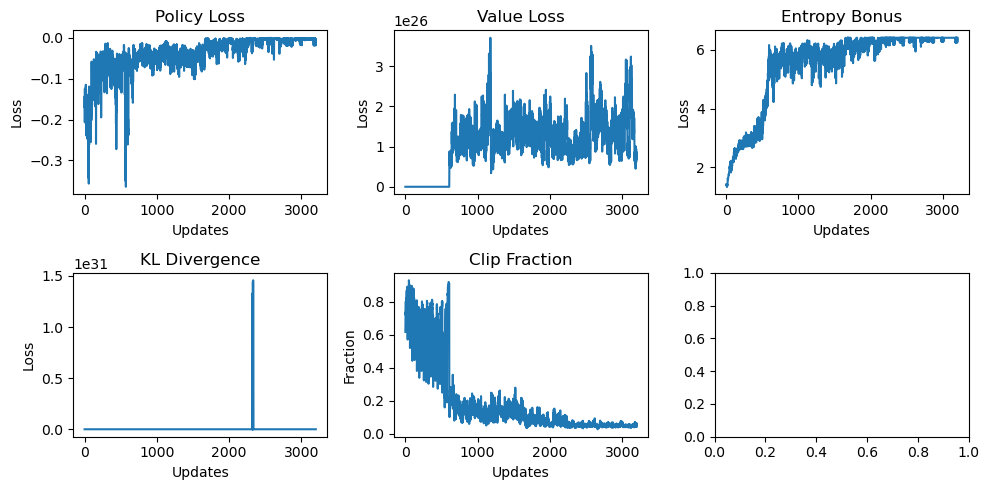

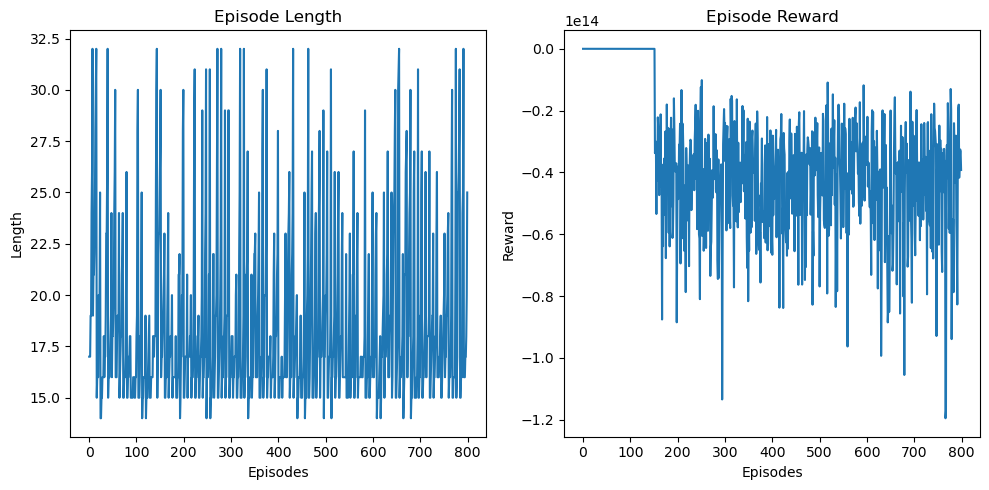

In [ ]:
trainer.plot()

if device == "mps":

else:
    trainer.log_video()